In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import AlgoLoop
import StatisticFunc

plt.style.use('Solarize_Light2')                     # 绘图风格
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 字体雅黑
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False    # 处理负号

# 预处理（剔除原油，铜，铁矿石）

## 提取并处理数据

### 权益类资产换手率

In [2]:
Turnovers = pd.read_excel(io="Raw/资产换手率.xlsx")                      # 读取数据
Turnovers = Turnovers.drop([0], axis=0)                                   # 删除多余行
Turnovers["日期"] = pd.DatetimeIndex(Turnovers["日期"])                    # 类型转换
Turnovers = Turnovers.set_index("日期")                                   # 设置索引

In [3]:
Turnovers = Turnovers[1:-1]

### GC007利率

In [4]:
Rates = pd.read_excel(io="Raw/GC007利率.xlsx")           #  读取数据
Rates = Rates.drop([0, 1, 2], axis=0)                   # 删除多余行
Rates.columns = ['日期', 'GC007']                        # 修改列名
Rates["日期"] = pd.DatetimeIndex(Rates["日期"])           # 类型转换
Rates = Rates.set_index("日期")                          # 设置索引

In [5]:
Rates = Rates[1:-1]                    

### 十年国债收益率

In [6]:
BondRates = pd.read_excel(io="Raw/中债国债到期收益率(中债)(日).xls")        # 读取数据
BondRates.columns = ['日期', '十年国债收益率']                             # 修改列名
BondRates = BondRates.drop([0, 3870, 3871], axis=0)                     # 删除多余行
BondRates["日期"] = pd.DatetimeIndex(BondRates["日期"])                   # 类型转换
BondRates = BondRates.set_index("日期")                                  # 设置索引

### 各资产收盘价

In [7]:
Assets = pd.read_excel(io="Raw/资产收盘价.xlsx")
Assets = Assets.drop([0], axis=0)                                   # 删除多余行
Assets["日期"] = pd.DatetimeIndex(Assets["日期"])                    # 类型转换
Assets = Assets.set_index("日期")                                   # 设置索引

### 十年国债价格指数

In [8]:
Data = Assets.merge(BondRates, how='left', left_index=True, right_index=True)

In [9]:
Data = Data.merge(Rates, how='left', left_index=True, right_index=True)

In [10]:
Data['持有时长'] = (Data.index - Data.index[0]).days
Data['10年国债价格指数'] = 100 - (Data['十年国债收益率'] - 3.0) * 8.2 + 3.0 * Data['持有时长'] / 365.0
Data['10年国债价格指数'] = Data['10年国债价格指数'].fillna(method='ffill')

In [11]:
# 利用自制10年国债价格指数，替换上证10年国债
Assets['中国10年国债'] = Data['10年国债价格指数'].values
Assets = Assets.drop('上证10年国债', axis=1)

## 计算各资产收益率

In [12]:
# 去掉没有10年国债数据的日期
Assets = Assets[:-10]

### 日内损益

In [13]:
Returns = Assets.pct_change(axis=0)
Returns = Returns.dropna(axis=0, how='all')           # 删除无数据日

In [14]:
drop_lst = ['中信证券COMEX铜期货', '中信证券WTI原油期货', '中信证券铁矿石', '标普500']
Returns = Returns.drop(drop_lst, axis=1)

In [15]:
Returns.tail()

,沪深300,中证500,信用债3-5AAA,中信证券COMEX黄金期货,中国10年国债
日期,,,,,
2020-06-18,0.006668,-0.000177,0.000089,-0.002171,0.001689
2020-06-19,0.013432,0.009198,-0.000031,0.012794,-0.001272
2020-06-22,0.000814,-0.000539,-0.001018,0.006962,-0.002197
2020-06-23,0.004814,0.003512,-0.001891,0.006070,0.000214
2020-06-24,0.004172,-0.002628,-0.000168,-0.005507,0.003104


### 累计损益

In [16]:
cumReturns = (1.0 + Returns)
cumReturns = cumReturns.fillna(1.0)                    # 填充空值
cumReturns = cumReturns.cumprod()                      # 计算各资产累计收益率

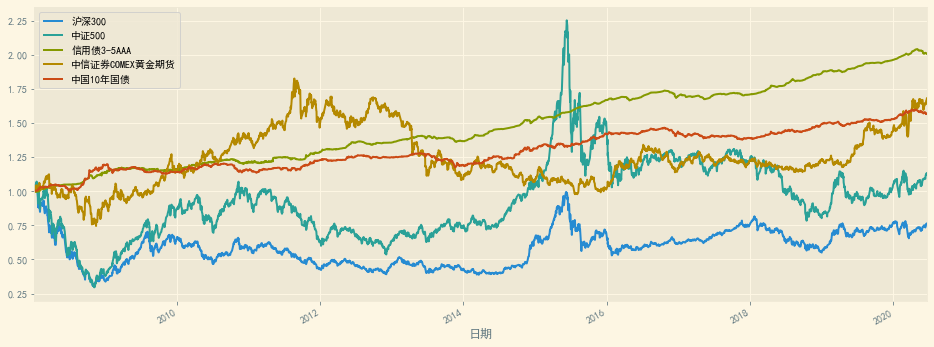

In [17]:
cumReturns.plot(figsize=(16, 6))

### 杠杆调整后的债券净值

In [18]:
lever = 2.0                                 # 杠杆
leverReturns = Returns.copy()               # 创建副本 
leverCumReturns = cumReturns.copy()   

# 更新杠杆调整后的债券净值
leverReturns.loc[:, ['中国10年国债', '信用债3-5AAA']] = Returns.loc[:, ['中国10年国债', '信用债3-5AAA']] * (1.0 + lever) - Rates.values * lever / (365.0 * 100)

# 更新累计净值
leverCumReturns = (1.0 + leverReturns)
leverCumReturns = leverCumReturns.fillna(1.0)                    # 填充空值
leverCumReturns = leverCumReturns.cumprod()                      # 计算各资产累计收益率

In [19]:
leverCumReturns.tail()

,沪深300,中证500,信用债3-5AAA,中信证券COMEX黄金期货,中国10年国债
日期,,,,,
2020-06-18,0.751032,1.119141,4.942358,1.640893,2.303008
2020-06-19,0.761120,1.129435,4.941123,1.661886,2.293859
2020-06-22,0.761740,1.128825,4.925184,1.673456,2.278346
2020-06-23,0.765407,1.132790,4.896426,1.683614,2.279431
2020-06-24,0.768600,1.129813,4.892953,1.674342,2.300194


# 风险平价 + 杠杆 + 指数权重

## 程序运行

In [20]:
tradeDF_base, weightDF_base = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema')

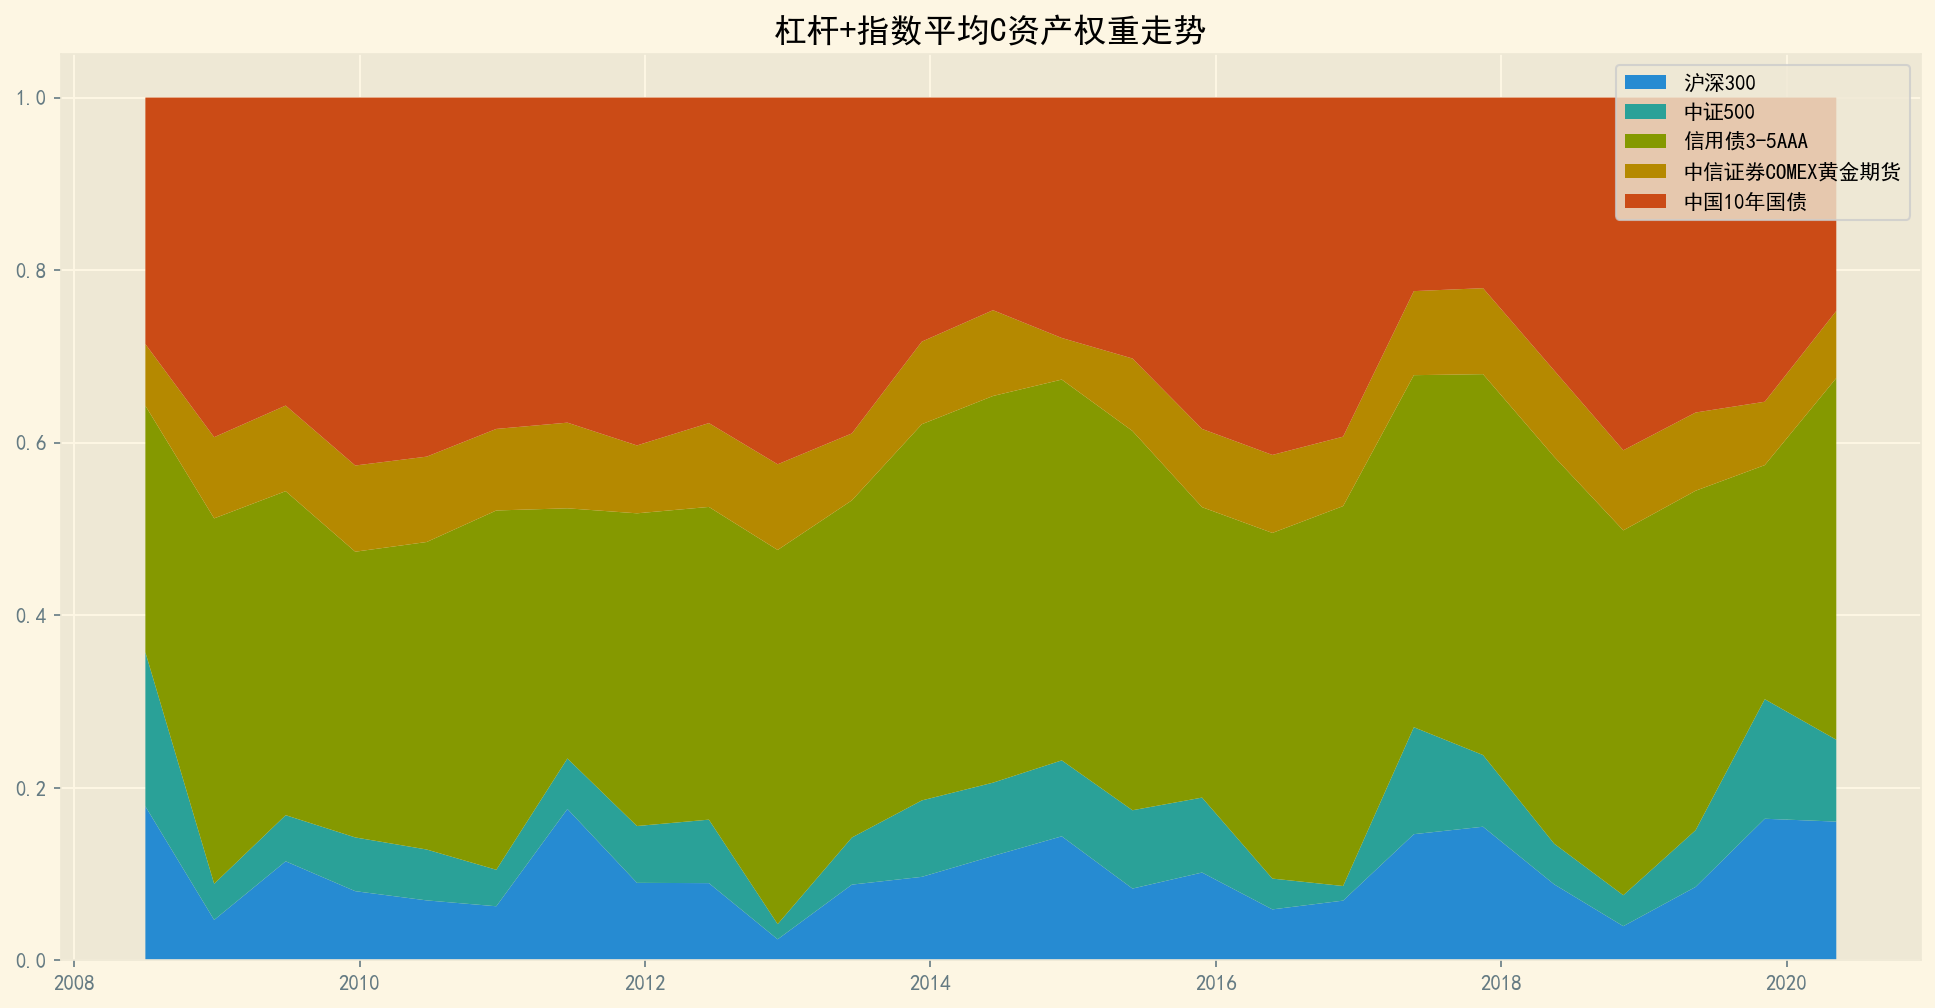

In [21]:
StatisticFunc.WeightPlot(tradeDF_base, weightDF_base, '杠杆+指数平均C')

## 回测表现汇总

In [22]:
# 表现汇总
years = np.unique(tradeDF_base.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_base = pd.DataFrame(index=years)

SummaryDF_base["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_base['投资组合净值']) )
SummaryDF_base["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_base['投资组合净值'])).values
SummaryDF_base["无基准夏普比率"] = SummaryDF_base['年收益率'] / SummaryDF_base['年波动率']
SummaryDF_base["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_base['最大回撤'])).values

SummaryDF_base

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.137905,0.166786,0.826837,-0.102252
2009,0.0778676,0.088260,0.882248,-0.055240
2010,0.0654674,0.066005,0.99186,-0.074328
2011,0.0610043,0.076467,0.797784,-0.092203
2012,0.0397277,0.045690,0.869512,-0.051353
2013,-0.102087,0.063540,-1.60665,-0.150207
2014,0.309355,0.057486,5.38143,-0.154190
2015,0.297621,0.079875,3.72607,-0.056014
2016,-0.0150667,0.057667,-0.261269,-0.100811
2017,-0.0244385,0.040574,-0.602316,-0.126786


## 收益率贡献度

In [23]:
annualContrb_base = StatisticFunc.AnnualContribution(tradeDF=tradeDF_base, weightDF=weightDF_base, assetDF=leverCumReturns)

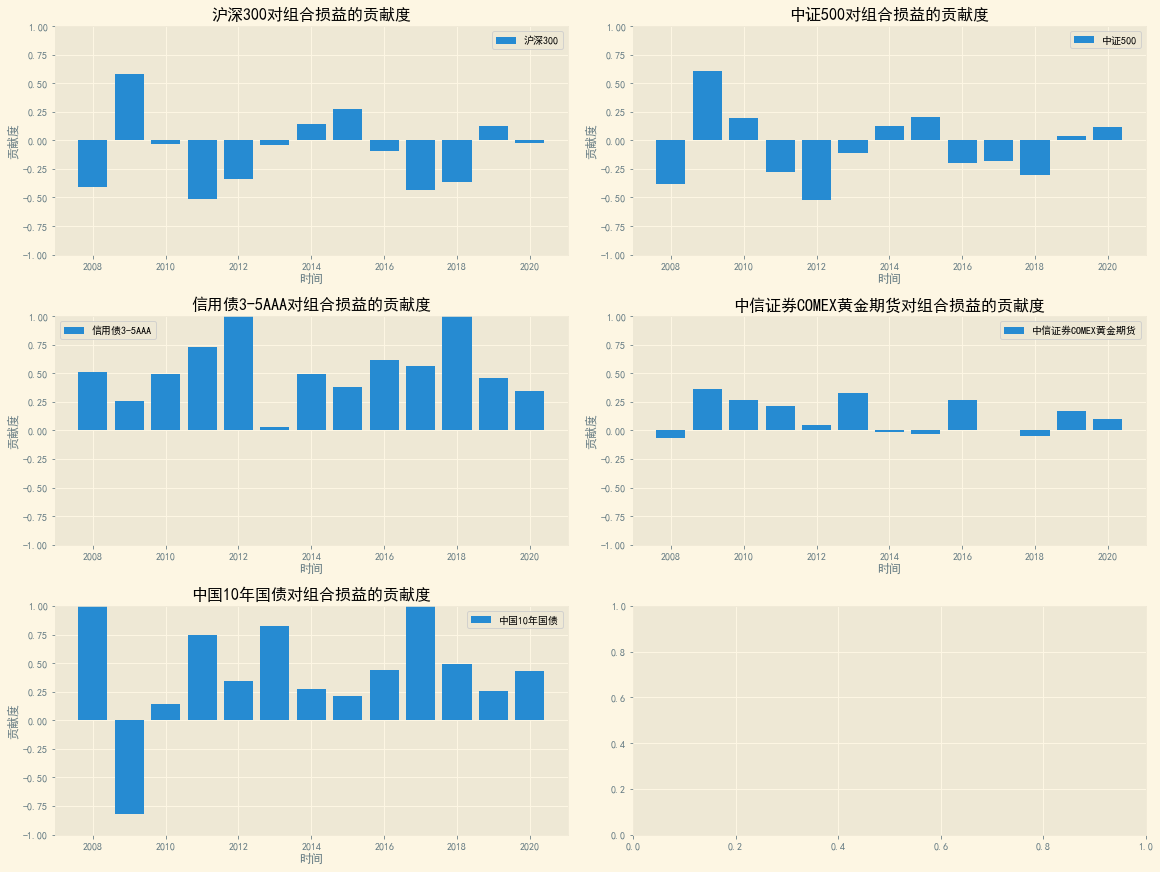

In [24]:
StatisticFunc.BarPlot(annualContrb_base, '杠杆+指数平均C')

## 投资组合净值曲线

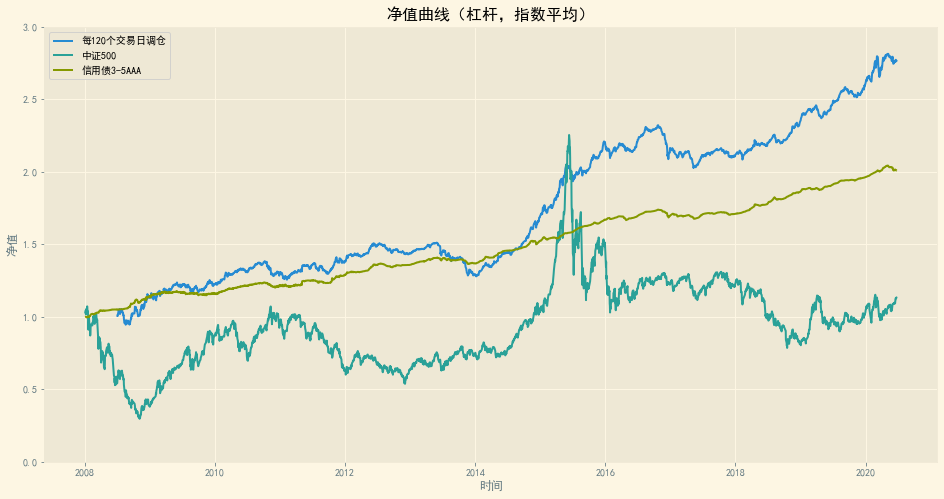

In [25]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_base.index, tradeDF_base['投资组合净值']/10000, label='每120个交易日调仓')
    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均）')
plt.savefig('净值曲线（杠杆，指数平均）C.png')

# 风险平价 + 杠杆 + 指数平均 + 多因子

## 基准组合（多因子）

### 程序运行

In [26]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':True}

tradeDF_multi, weightDF_multi = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

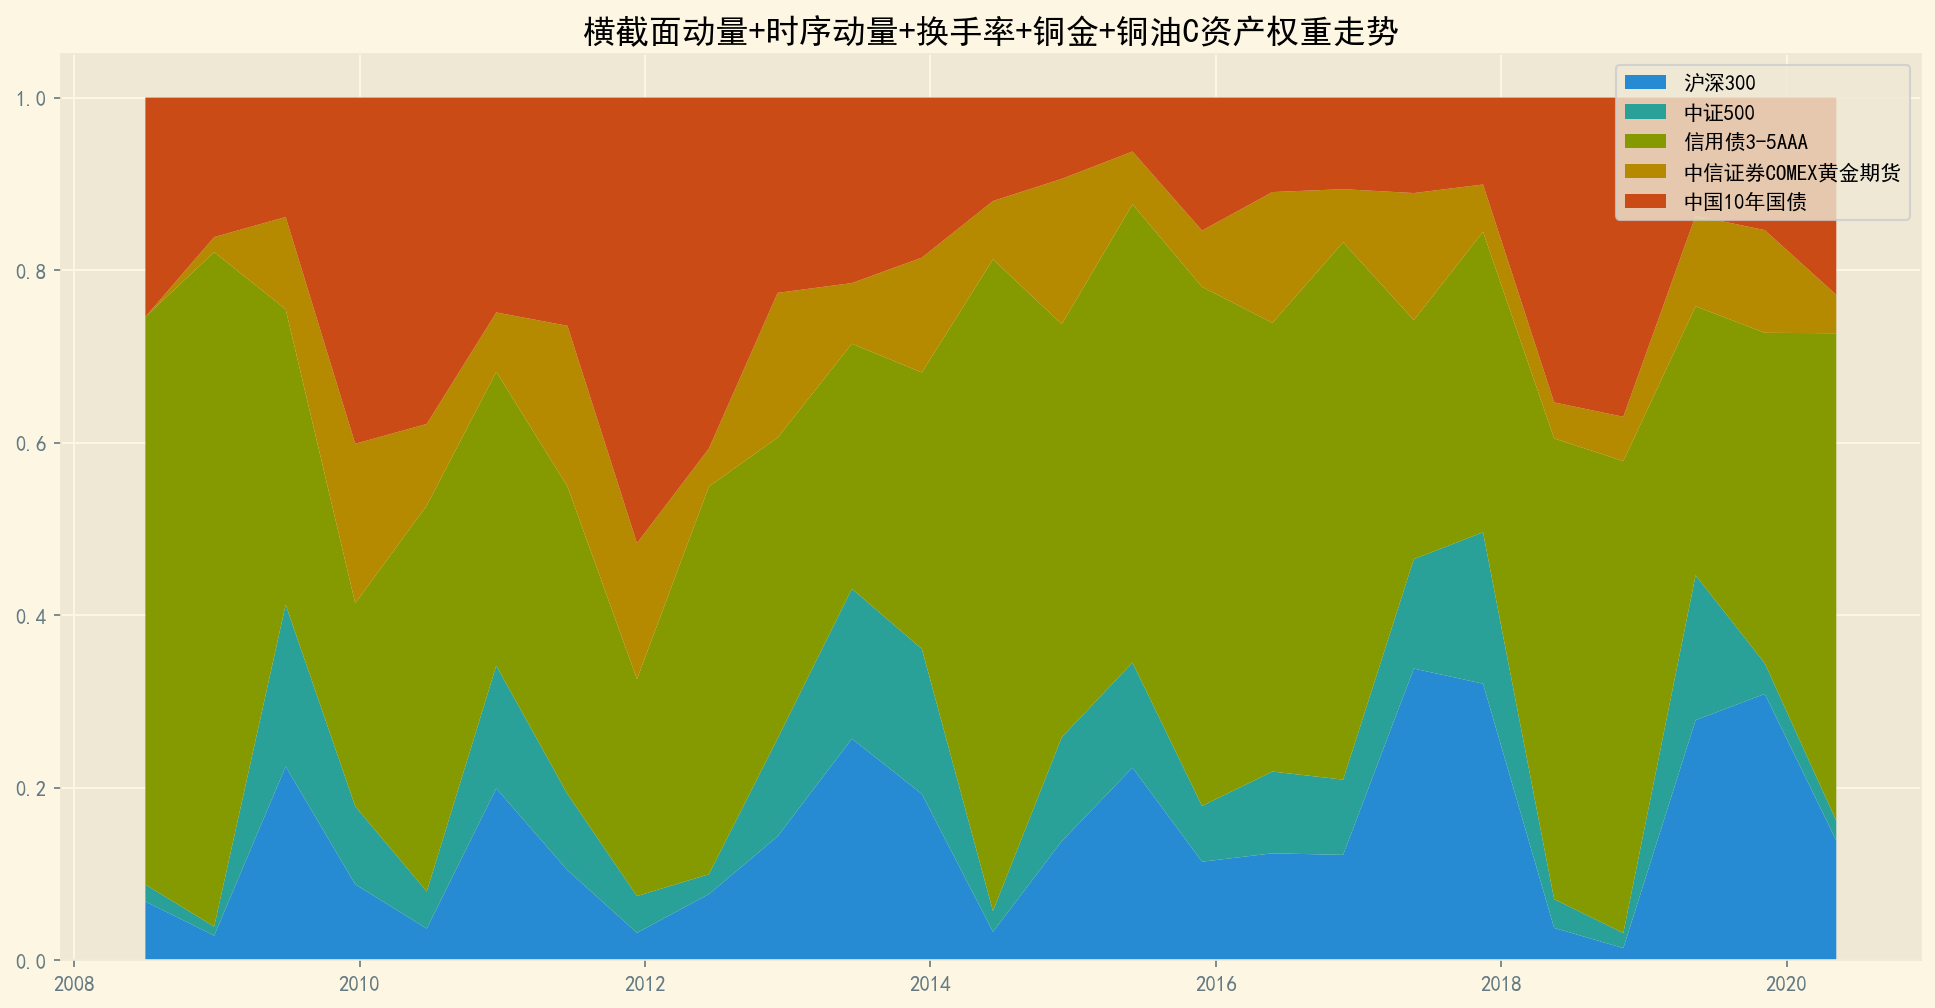

In [27]:
StatisticFunc.WeightPlot(tradeDF_multi, weightDF_multi, '横截面动量+时序动量+换手率+铜金+铜油C')

### 回测表现汇总

In [28]:
# 表现汇总
years = np.unique(tradeDF_multi.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_multi = pd.DataFrame(index=years)

SummaryDF_multi["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_multi['投资组合净值']) )
SummaryDF_multi["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_multi['投资组合净值'])).values
SummaryDF_multi["无基准夏普比率"] = SummaryDF_multi['年收益率'] / SummaryDF_multi['年波动率']
SummaryDF_multi["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_multi['最大回撤'])).values

SummaryDF_multi

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.302383,0.132678,2.27907,-0.045878
2009,0.137279,0.137820,0.996075,-0.104318
2010,0.0369912,0.068422,0.540636,-0.091078
2011,0.0369328,0.084110,0.439103,-0.115487
2012,0.0608168,0.046610,1.3048,-0.051942
2013,-0.0738412,0.096623,-0.764224,-0.121061
2014,0.224407,0.059800,3.75263,-0.126798
2015,0.241971,0.114284,2.11727,-0.113110
2016,-0.00398852,0.054760,-0.0728364,-0.083639
2017,0.0238276,0.050344,0.4733,-0.107878


### 收益率贡献度

In [29]:
annualContrb_multi = StatisticFunc.AnnualContribution(tradeDF=tradeDF_multi, weightDF=weightDF_multi, assetDF=leverCumReturns)

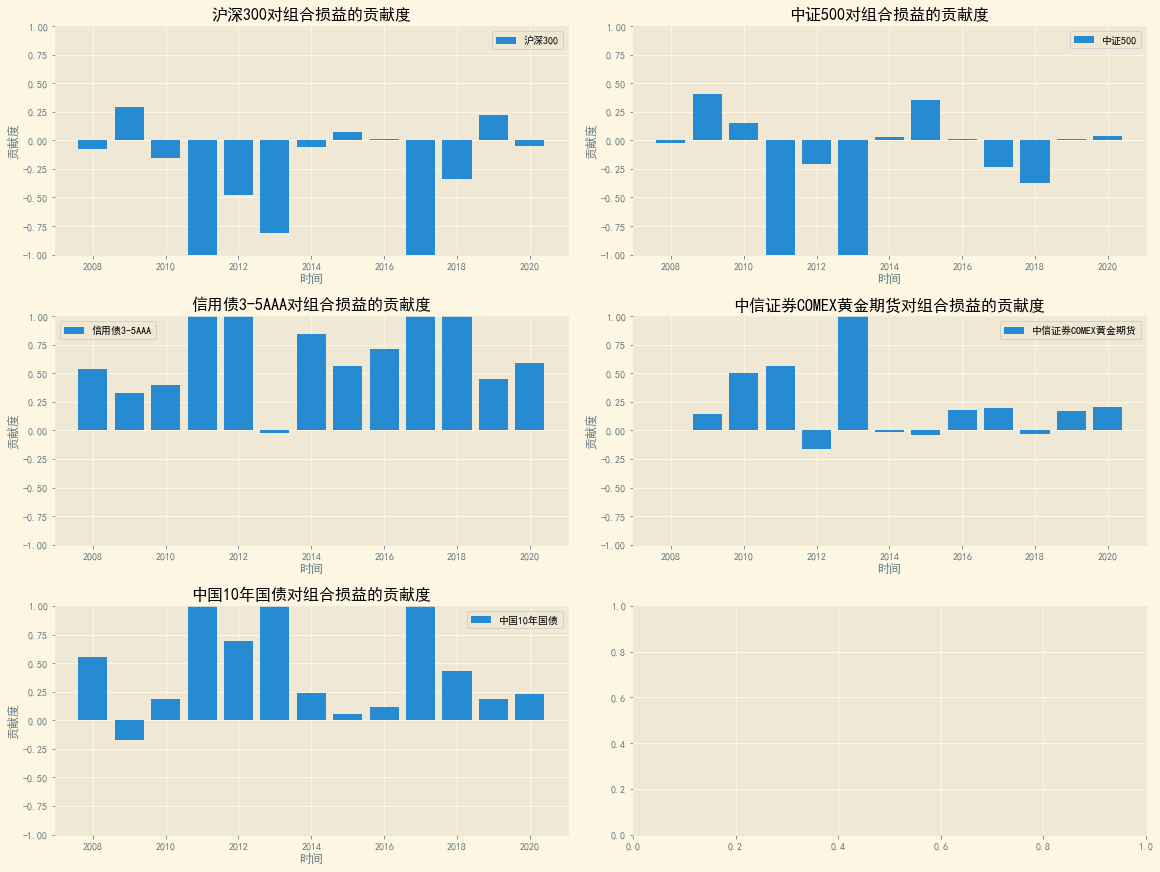

In [30]:
StatisticFunc.BarPlot(annualContrb_multi, '横截面动量+时序动量+换手率+铜金+铜油C')

### 投资组合净值曲线

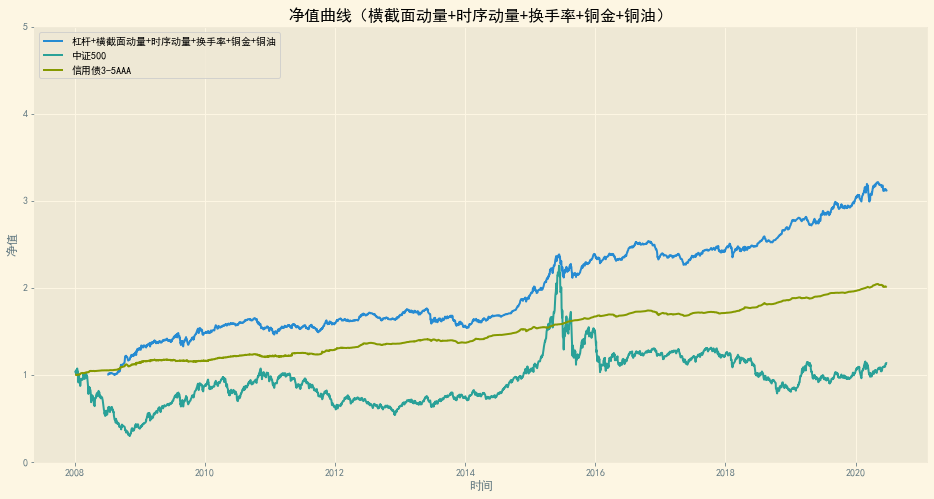

In [31]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_multi.index, tradeDF_multi['投资组合净值']/10000, label='杠杆+横截面动量+时序动量+换手率+铜金+铜油')
    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（横截面动量+时序动量+换手率+铜金+铜油）')
plt.savefig('净值曲线（横截面动量+时序动量+换手率+铜金+铜油）C.png')

## 换手率

### 程序运行

In [32]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':False, 'copperGas':False}

tradeDF_1, weightDF_1 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

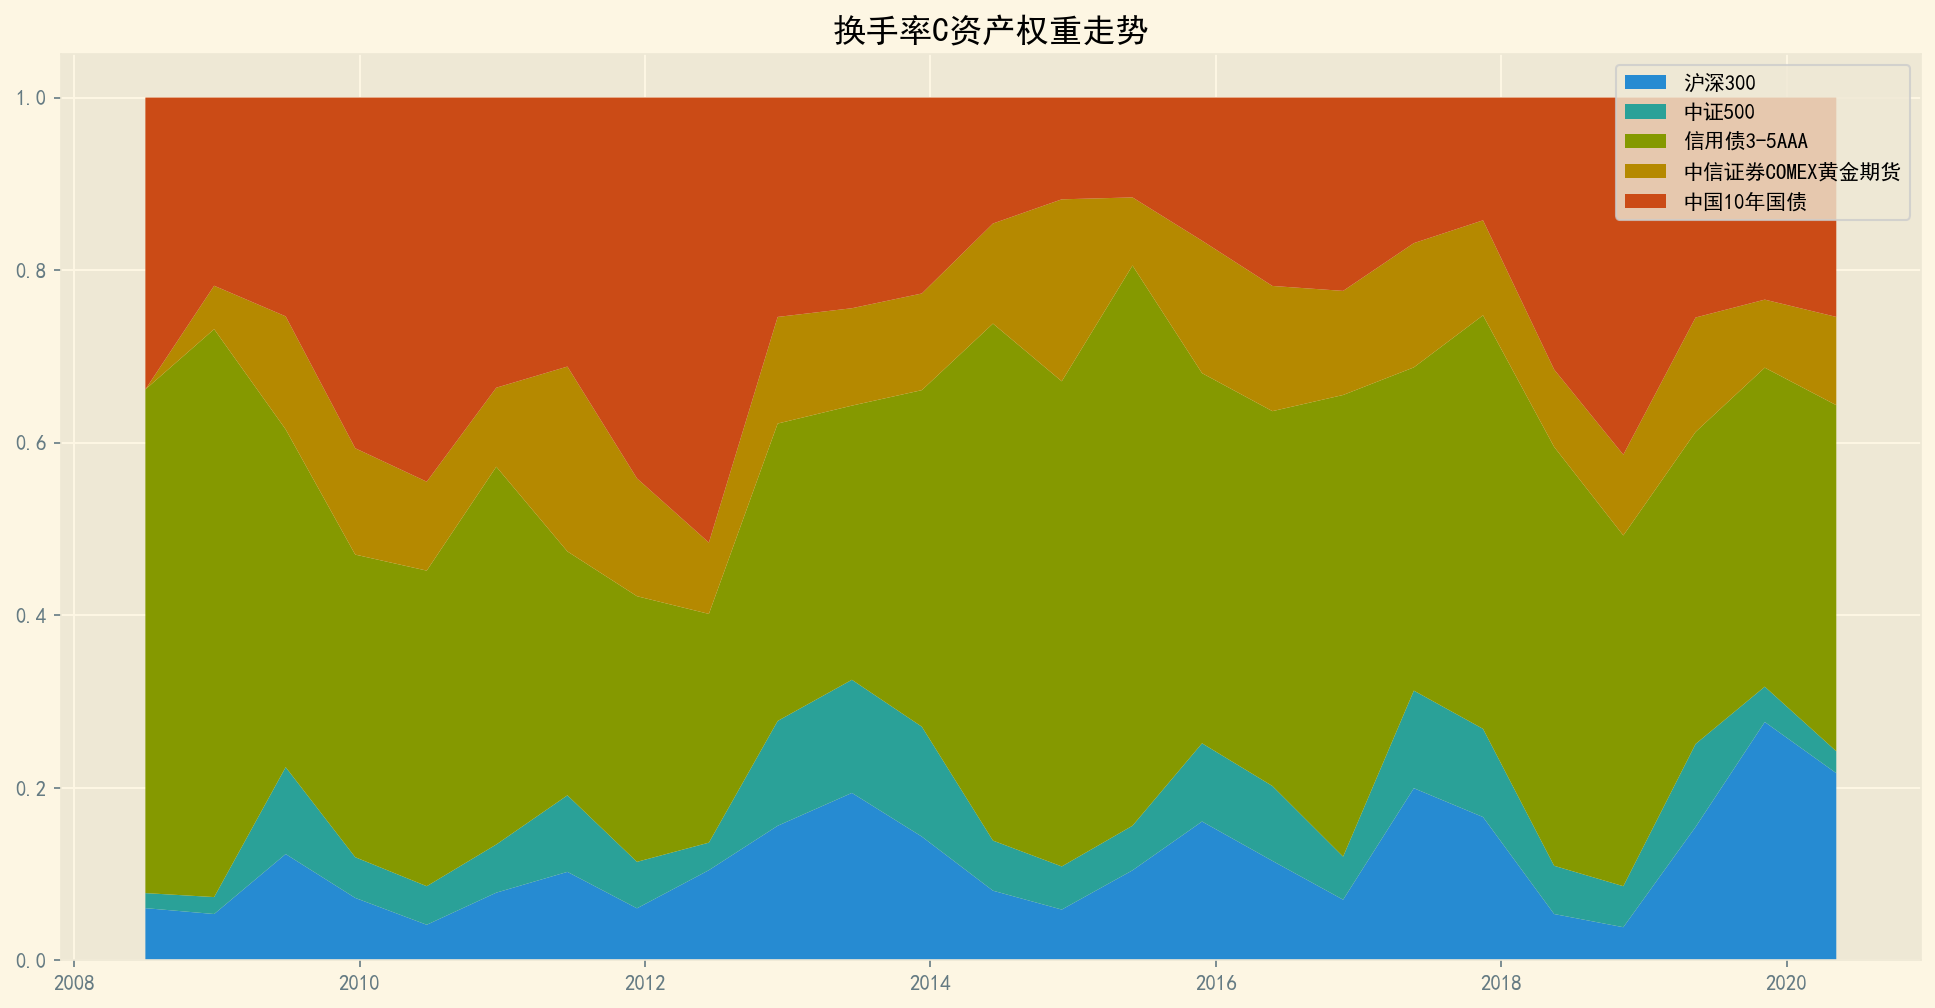

In [33]:
StatisticFunc.WeightPlot(tradeDF_1, weightDF_1, '换手率C')

### 回测表现汇总

In [34]:
# 表现汇总
years = np.unique(tradeDF_1.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_1 = pd.DataFrame(index=years)

SummaryDF_1["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_1['投资组合净值']) )
SummaryDF_1["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_1['投资组合净值'])).values
SummaryDF_1["无基准夏普比率"] = SummaryDF_1['年收益率'] / SummaryDF_1['年波动率']
SummaryDF_1["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_1['最大回撤'])).values

SummaryDF_1

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.337948,0.135052,2.50236,-0.041019
2009,0.114589,0.101970,1.12374,-0.057524
2010,0.0612072,0.064787,0.944748,-0.082298
2011,0.0640439,0.080216,0.798392,-0.098483
2012,0.0722741,0.048893,1.47822,-0.048873
2013,-0.0804519,0.087167,-0.922958,-0.134474
2014,0.240872,0.051799,4.65009,-0.138993
2015,0.224674,0.060722,3.70002,-0.042675
2016,-0.00675138,0.064768,-0.104239,-0.089153
2017,-0.00290071,0.040113,-0.0723141,-0.110009


### 收益率贡献度

In [35]:
annualContrb_1 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_1, weightDF=weightDF_1, assetDF=leverCumReturns)

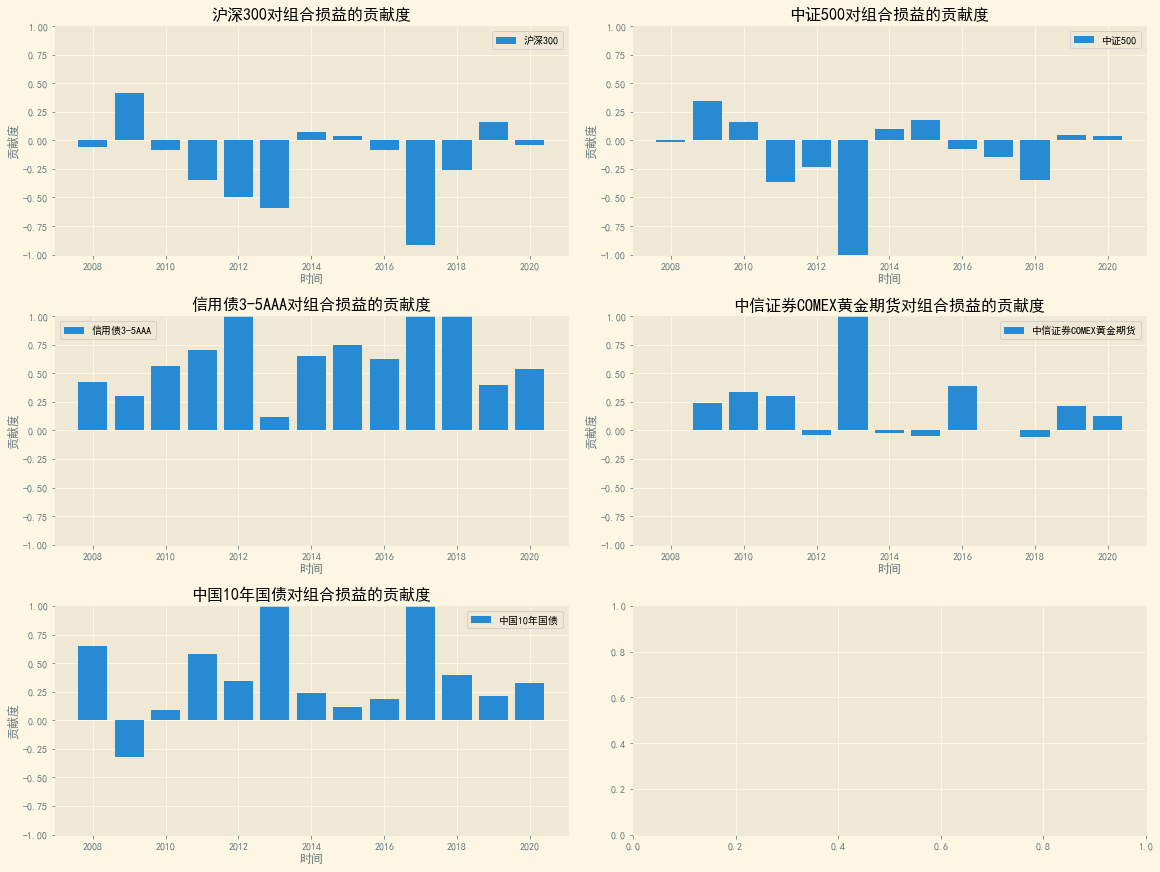

In [36]:
StatisticFunc.BarPlot(annualContrb_1, '换手率C')

### 投资组合净值曲线

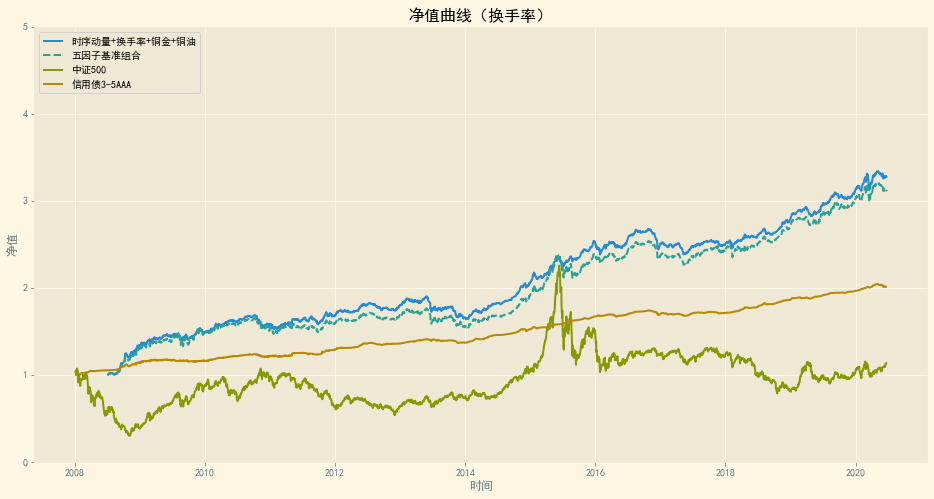

In [37]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_1.index, tradeDF_1['投资组合净值']/10000, label='时序动量+换手率+铜金+铜油')

# 基准参考
plt.plot(tradeDF_multi.index, tradeDF_multi['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（换手率）')
plt.savefig('净值曲线（换手率）C.png')

## 横截面动量

### 程序运行

In [38]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 
            'copperGold':False, 'copperGas':False}

tradeDF_2, weightDF_2 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

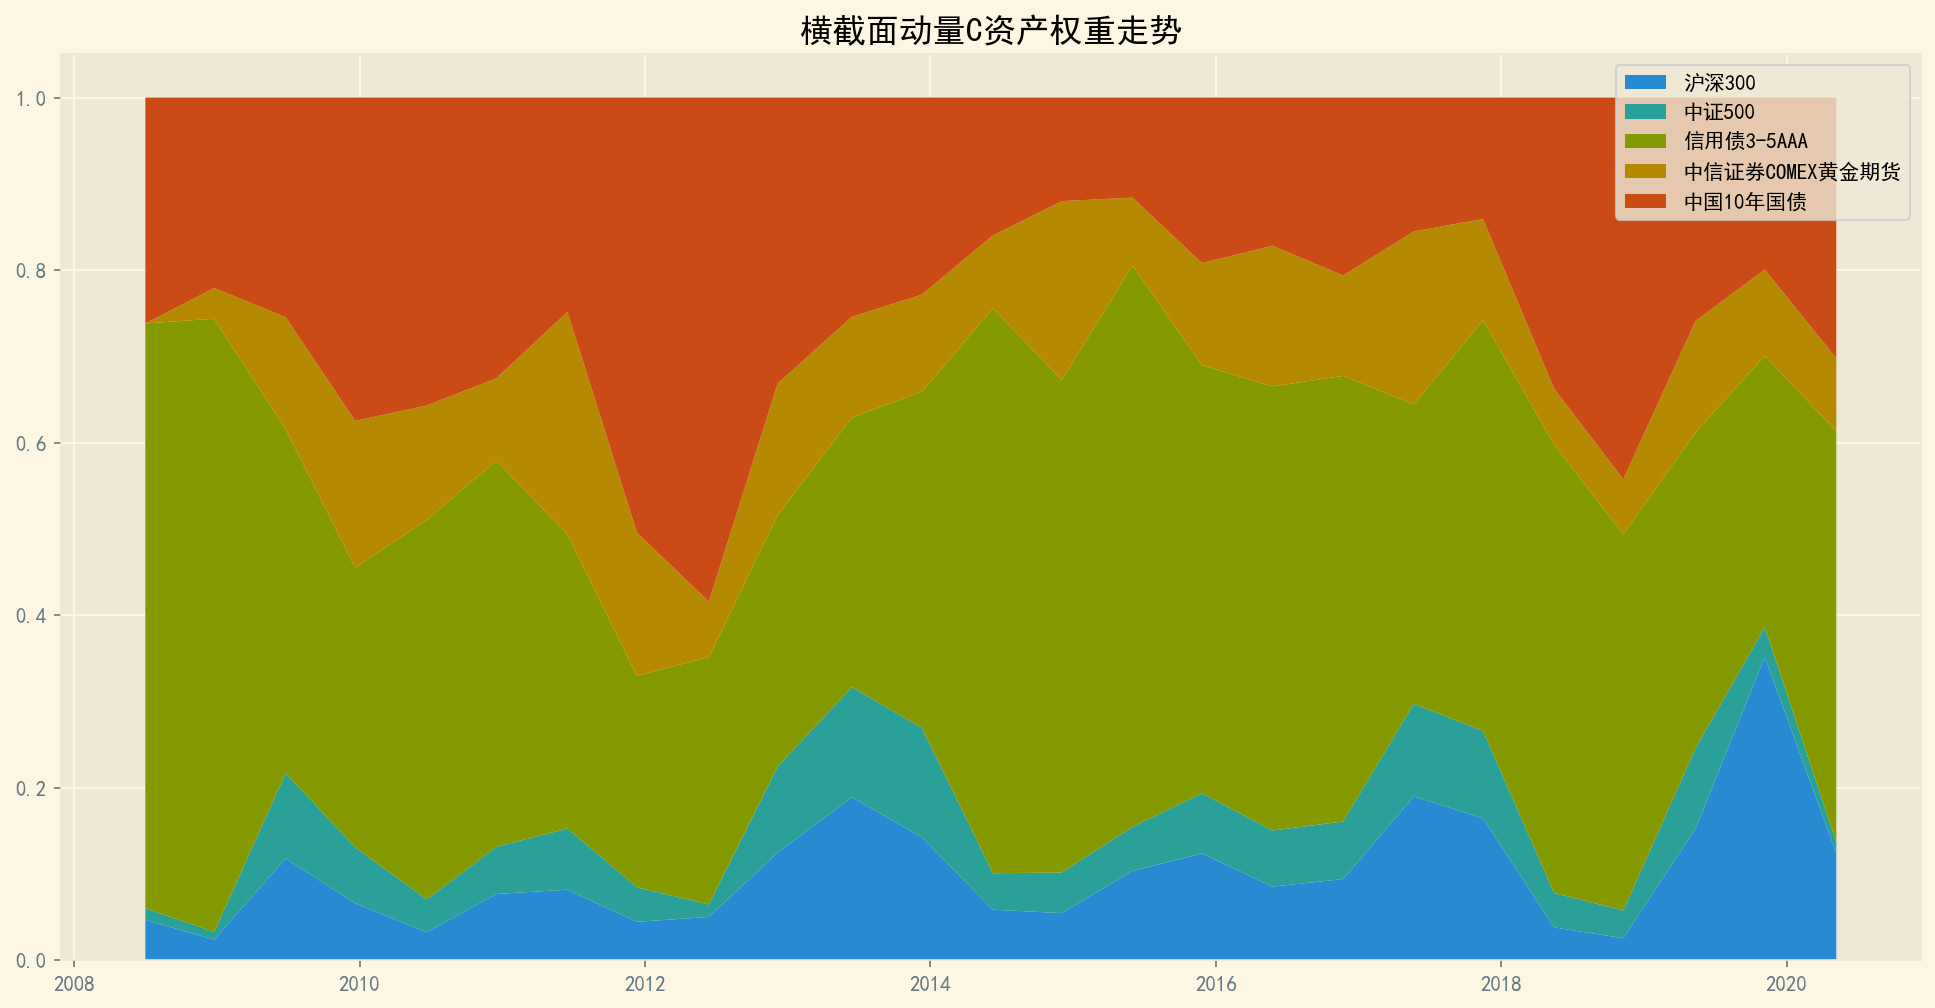

In [39]:
StatisticFunc.WeightPlot(tradeDF_2, weightDF_2, '横截面动量C')

### 回测表现汇总

In [40]:
# 表现汇总
years = np.unique(tradeDF_2.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_2 = pd.DataFrame(index=years)

SummaryDF_2["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_2['投资组合净值']) )
SummaryDF_2["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_2['投资组合净值'])).values
SummaryDF_2["无基准夏普比率"] = SummaryDF_2['年收益率'] / SummaryDF_2['年波动率']
SummaryDF_2["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_2['最大回撤'])).values

SummaryDF_2

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.319337,0.133977,2.38351,-0.044437
2009,0.0864566,0.102373,0.844523,-0.056148
2010,0.0649998,0.064263,1.01147,-0.077148
2011,0.0697343,0.082734,0.842872,-0.095223
2012,0.064279,0.047780,1.34531,-0.050046
2013,-0.0885695,0.083700,-1.05818,-0.132698
2014,0.236235,0.051492,4.58779,-0.137207
2015,0.222479,0.058998,3.77095,-0.042249
2016,-0.00313019,0.056050,-0.0558462,-0.089712
2017,-0.00431475,0.040527,-0.106465,-0.110030


### 收益率贡献度

In [41]:
annualContrb_2 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_2, weightDF=weightDF_2, assetDF=leverCumReturns)

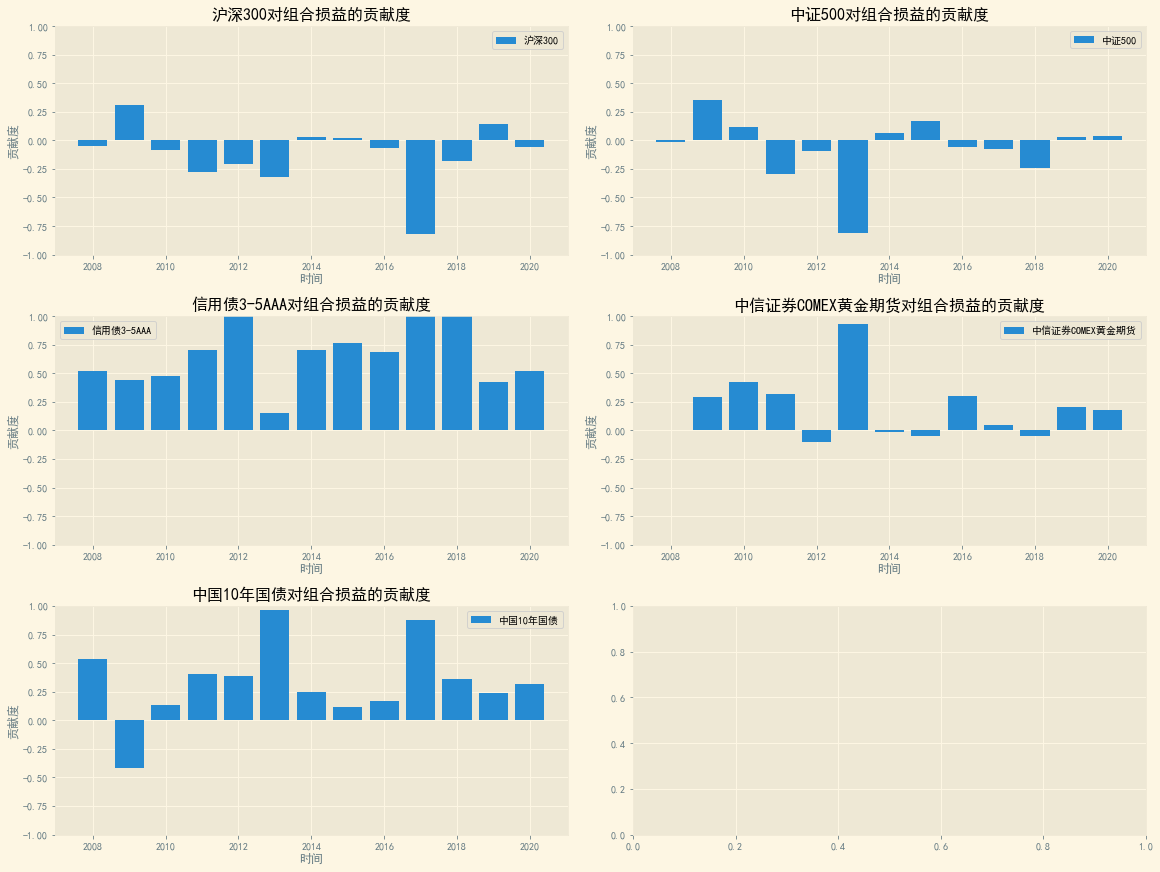

In [42]:
StatisticFunc.BarPlot(annualContrb_2, '横截面动量C')

### 投资组合净值曲线

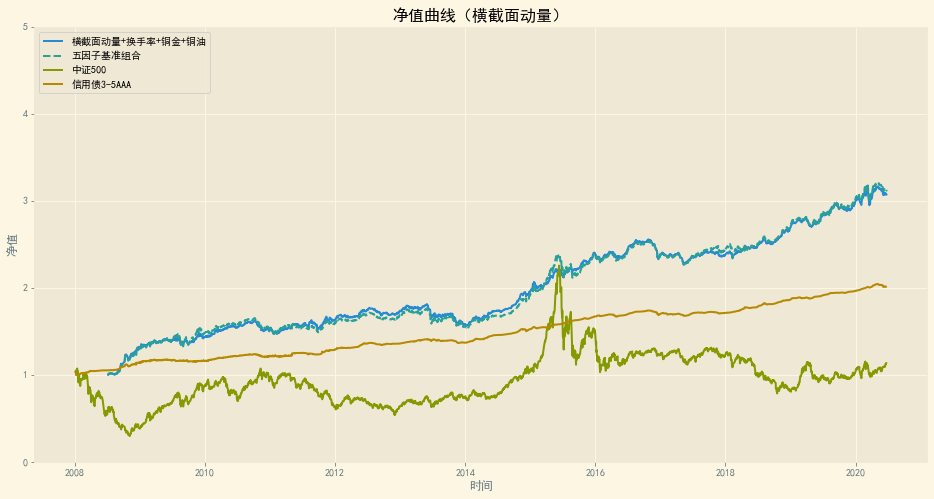

In [43]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_2.index, tradeDF_2['投资组合净值']/10000, label='横截面动量+换手率+铜金+铜油')
    
# 基准参考
plt.plot(tradeDF_multi.index, tradeDF_multi['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（横截面动量）')
plt.savefig('净值曲线（横截面动量）C.png')

## 时序动量

### 程序运行

In [44]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 
            'copperGold':False, 'copperGas':False}

tradeDF_3, weightDF_3 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

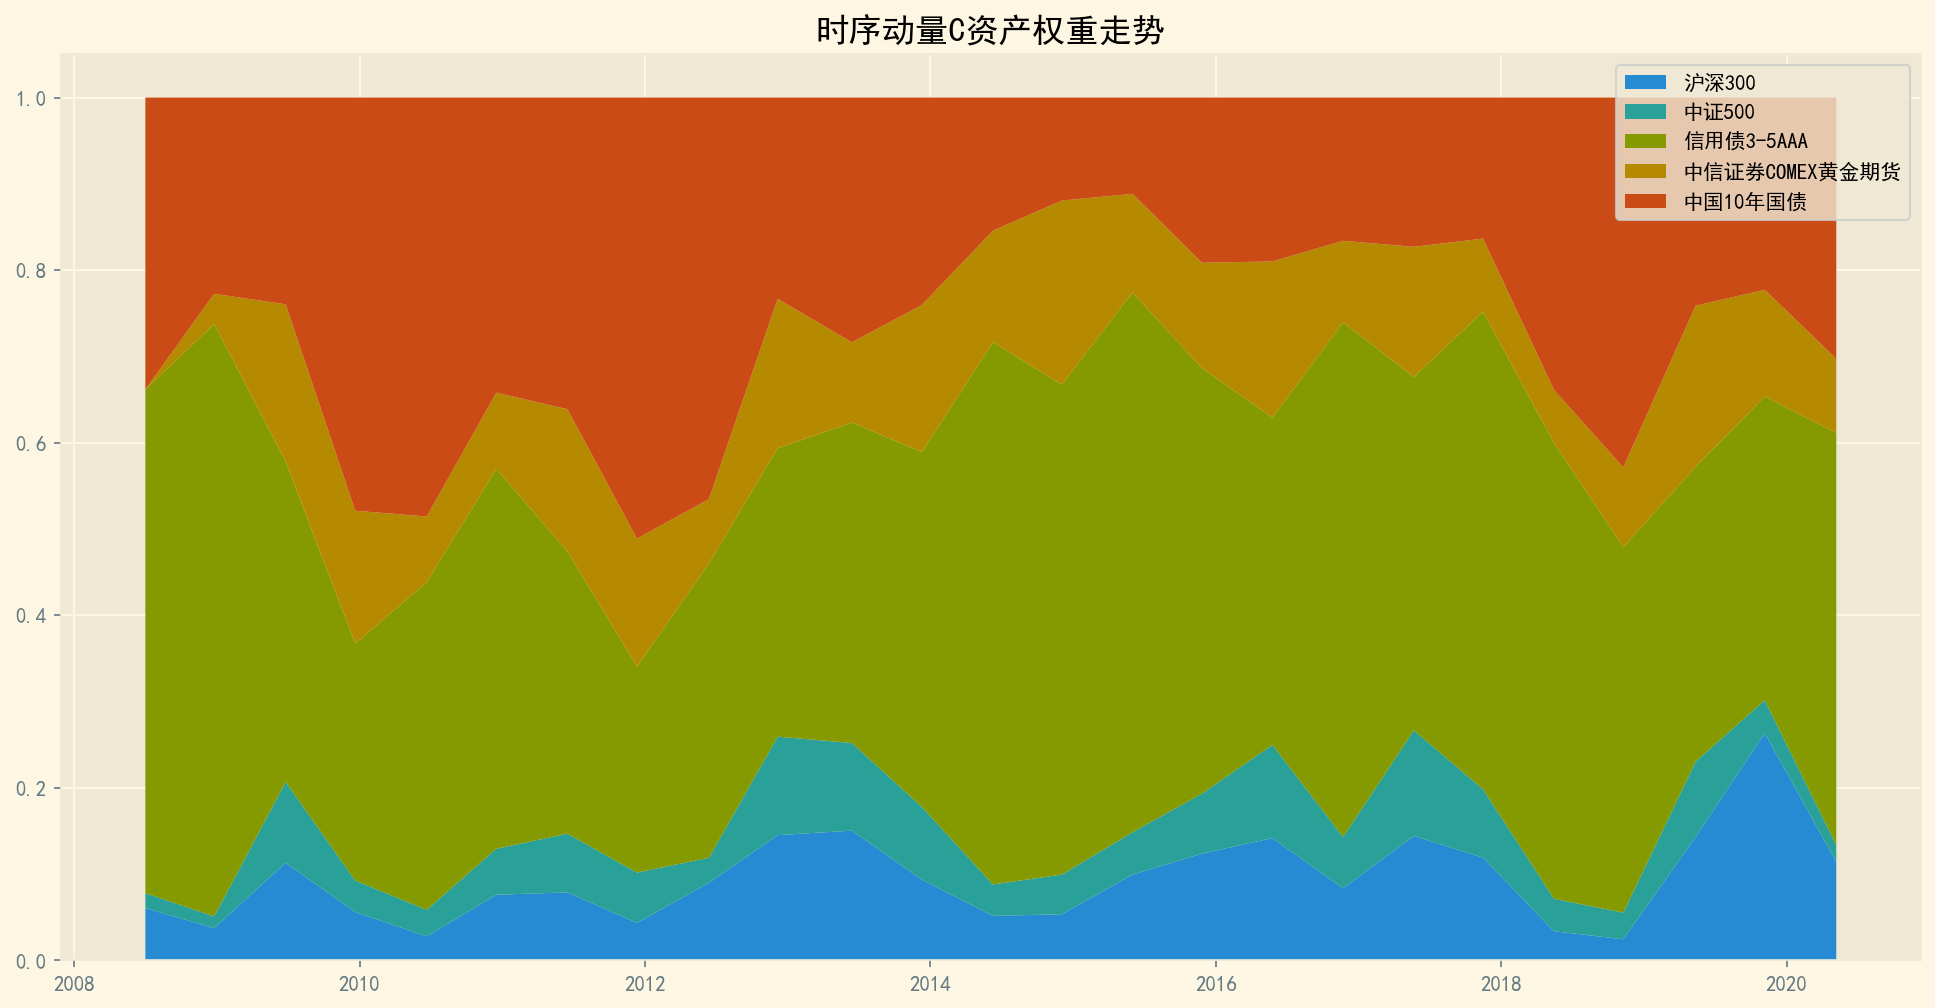

In [45]:
StatisticFunc.WeightPlot(tradeDF_3, weightDF_3, '时序动量C')

### 回测表现汇总

In [46]:
# 表现汇总
years = np.unique(tradeDF_3.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_3 = pd.DataFrame(index=years)

SummaryDF_3["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_3['投资组合净值']) )
SummaryDF_3["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_3['投资组合净值'])).values
SummaryDF_3["无基准夏普比率"] = SummaryDF_3['年收益率'] / SummaryDF_3['年波动率']
SummaryDF_3["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_3['最大回撤'])).values

SummaryDF_3

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.338418,0.135097,2.50499,-0.041019
2009,0.105663,0.101973,1.03619,-0.053857
2010,0.0541014,0.066597,0.812375,-0.091961
2011,0.0763819,0.077230,0.989019,-0.105747
2012,0.0610901,0.047995,1.27284,-0.047678
2013,-0.103848,0.081154,-1.27964,-0.145346
2014,0.237779,0.048186,4.93459,-0.147342
2015,0.21509,0.058445,3.6802,-0.041051
2016,0.00146735,0.059215,0.02478,-0.085747
2017,-0.0100371,0.037286,-0.269196,-0.108392


### 收益率贡献度

In [47]:
annualContrb_3 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_3, weightDF=weightDF_3, assetDF=leverCumReturns)

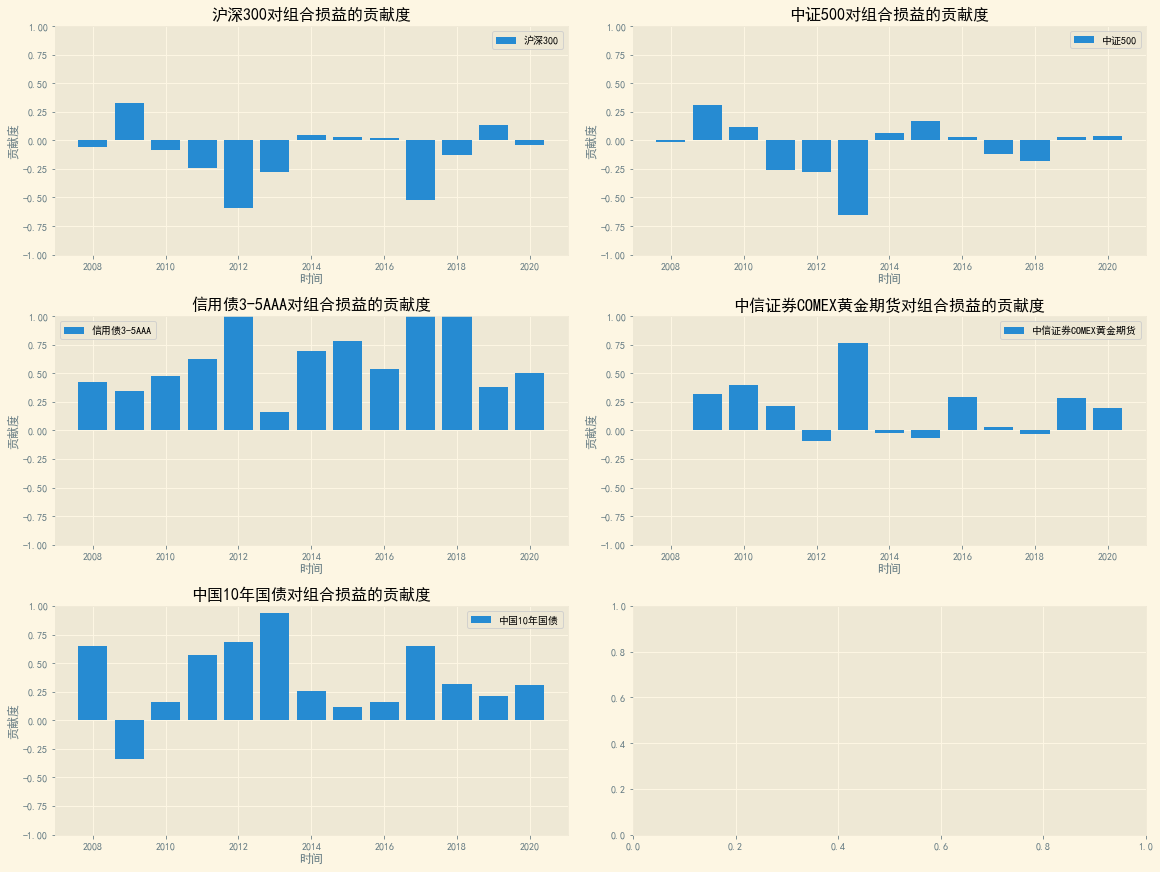

In [48]:
StatisticFunc.BarPlot(annualContrb_3, '时序动量C')

### 投资组合净值曲线

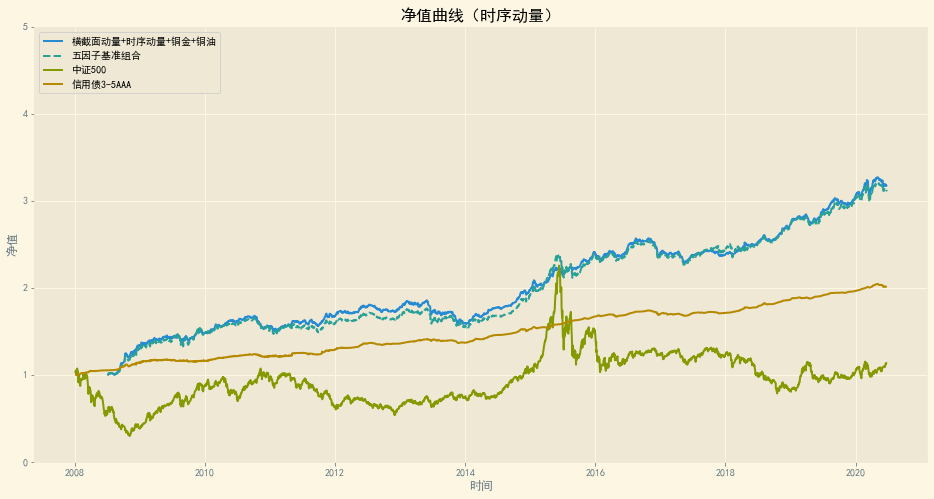

In [49]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_3.index, tradeDF_3['投资组合净值']/10000, label='横截面动量+时序动量+铜金+铜油')
    
# 基准参考
plt.plot(tradeDF_multi.index, tradeDF_multi['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（时序动量）')
plt.savefig('净值曲线（时序动量）C.png')

## 铜金

### 程序运行

In [50]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 
            'copperGold':True, 'copperGas':False}

tradeDF_4, weightDF_4 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

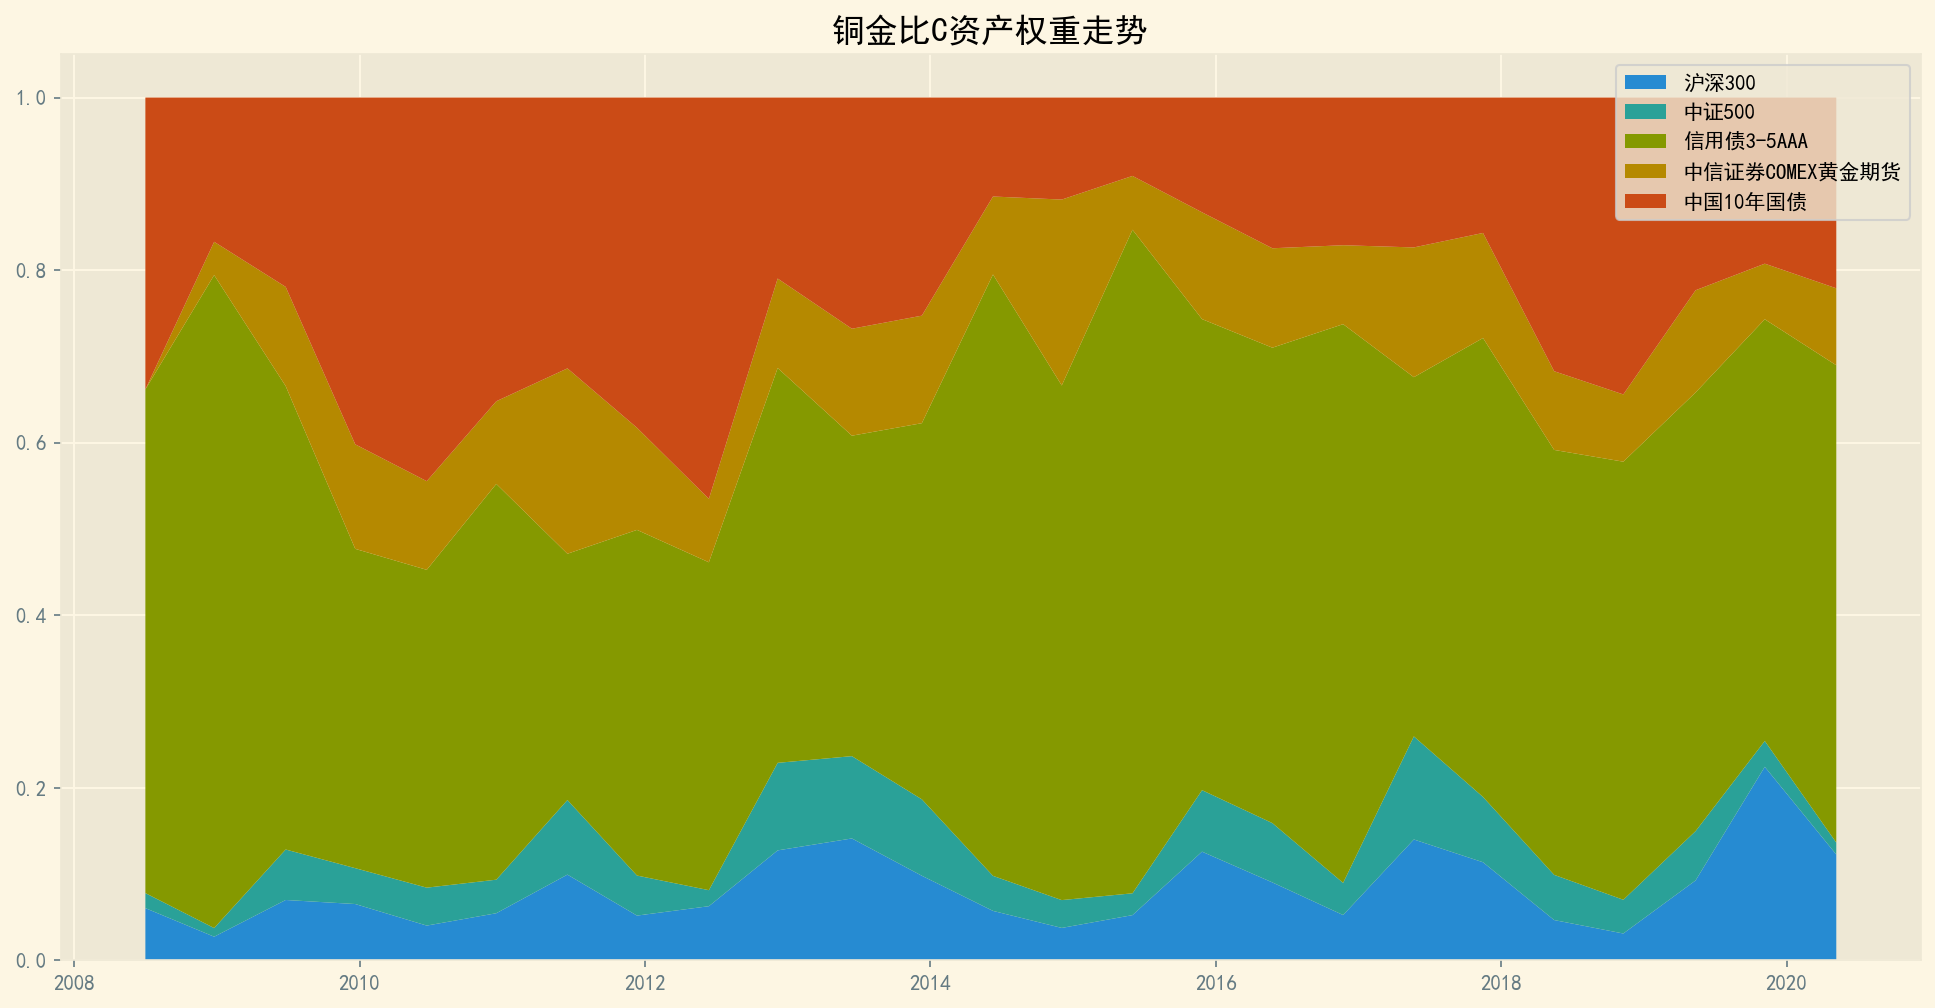

In [51]:
StatisticFunc.WeightPlot(tradeDF_4, weightDF_4, '铜金比C')

### 回测表现汇总

In [52]:
# 表现汇总
years = np.unique(tradeDF_4.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_4 = pd.DataFrame(index=years)

SummaryDF_4["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_4['投资组合净值']) )
SummaryDF_4["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_4['投资组合净值'])).values
SummaryDF_4["无基准夏普比率"] = SummaryDF_4['年收益率'] / SummaryDF_4['年波动率']
SummaryDF_4["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_4['最大回撤'])).values

SummaryDF_4

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.341389,0.135511,2.51928,-0.041019
2009,0.0770559,0.095129,0.810016,-0.054657
2010,0.0668216,0.064297,1.03927,-0.082551
2011,0.0730454,0.080011,0.912943,-0.096909
2012,0.082887,0.044745,1.85243,-0.047352
2013,-0.0837103,0.076078,-1.10033,-0.141545
2014,0.247169,0.047052,5.25307,-0.145137
2015,0.236894,0.045778,5.17481,-0.036279
2016,-0.00130302,0.055839,-0.0233352,-0.089714
2017,-0.013726,0.036452,-0.376552,-0.113870


### 收益率贡献度

In [53]:
annualContrb_4 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_4, weightDF=weightDF_4, assetDF=leverCumReturns)

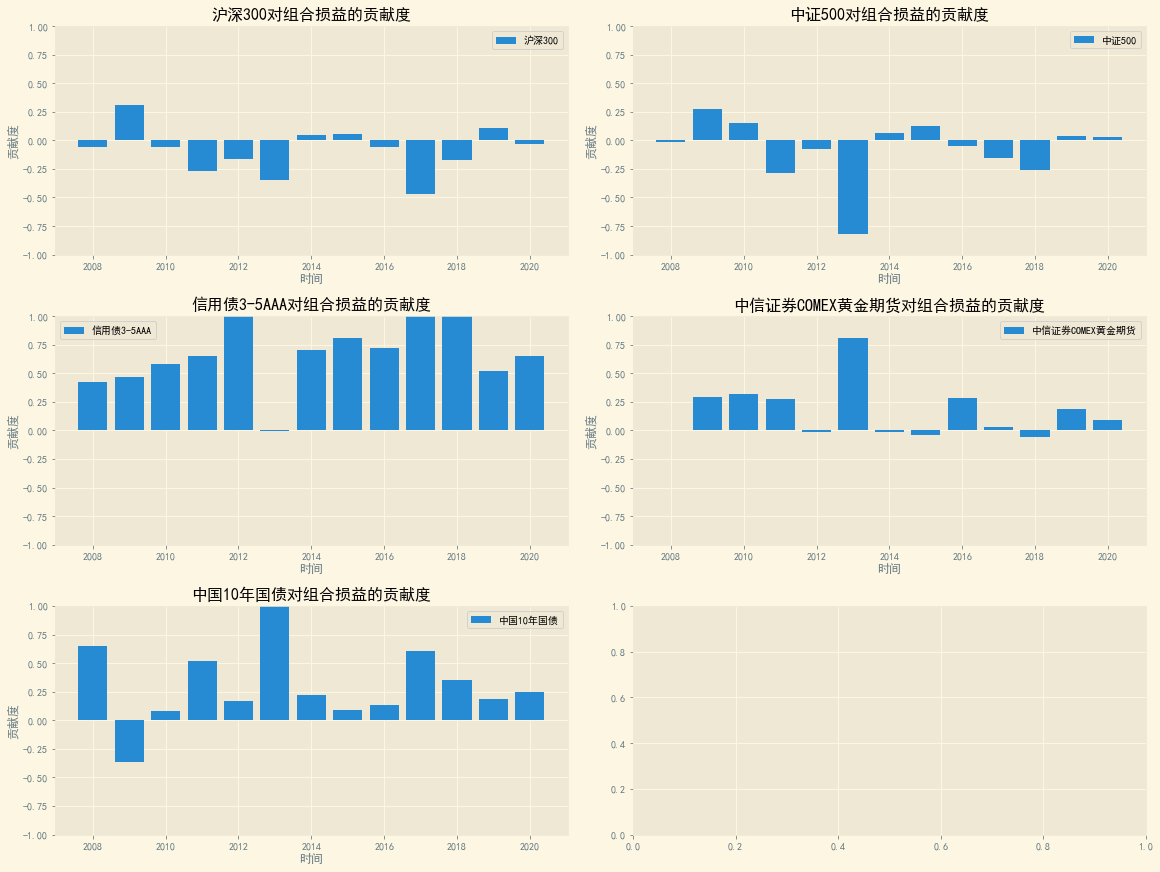

In [54]:
StatisticFunc.BarPlot(annualContrb_4, '铜金比C')

### 投资组合净值曲线

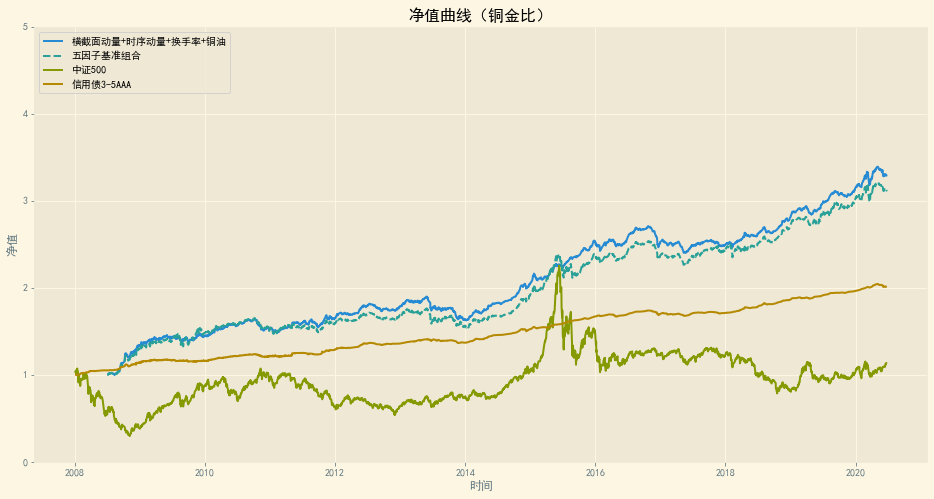

In [55]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_4.index, tradeDF_4['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜油')
    
# 基准参考
plt.plot(tradeDF_multi.index, tradeDF_multi['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（铜金比）')
plt.savefig('净值曲线（铜金比）C.png')

## 铜油

### 程序运行

In [56]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 
            'copperGold':False, 'copperGas':True}

tradeDF_5, weightDF_5 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

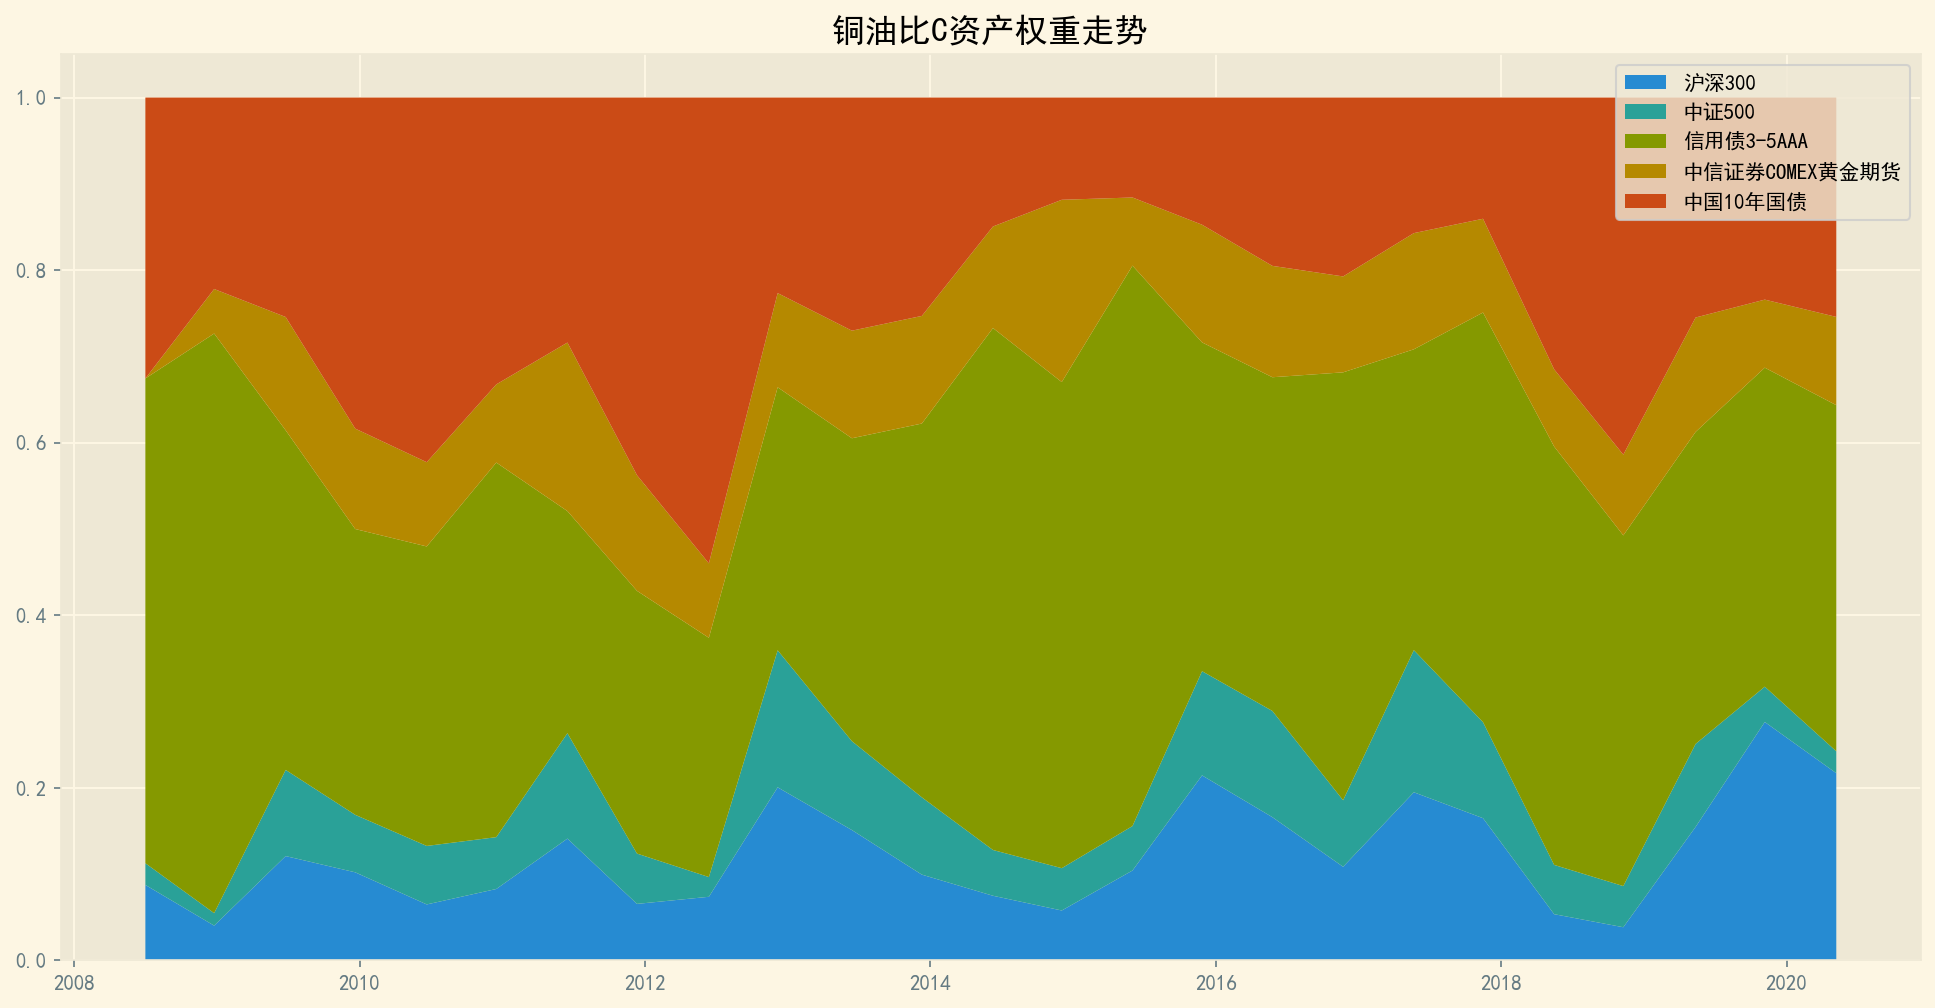

In [57]:
StatisticFunc.WeightPlot(tradeDF_5, weightDF_5, '铜油比C')

### 回测表现汇总

In [58]:
# 表现汇总
years = np.unique(tradeDF_5.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_5 = pd.DataFrame(index=years)

SummaryDF_5["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_5['投资组合净值']) )
SummaryDF_5["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_5['投资组合净值'])).values
SummaryDF_5["无基准夏普比率"] = SummaryDF_5['年收益率'] / SummaryDF_5['年波动率']
SummaryDF_5["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_5['最大回撤'])).values

SummaryDF_5

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.315293,0.133715,2.35795,-0.042926
2009,0.103884,0.101636,1.02211,-0.056670
2010,0.0587357,0.067139,0.874831,-0.073815
2011,0.0445526,0.081928,0.543805,-0.091761
2012,0.0910079,0.050815,1.79098,-0.046120
2013,-0.092454,0.088448,-1.04529,-0.149614
2014,0.254577,0.048654,5.23236,-0.153190
2015,0.224054,0.061863,3.62175,-0.042555
2016,-0.0206883,0.078480,-0.263612,-0.087027
2017,0.00486373,0.043150,0.112718,-0.104730


### 收益率贡献度

In [59]:
annualContrb_5 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_5, weightDF=weightDF_5, assetDF=leverCumReturns)

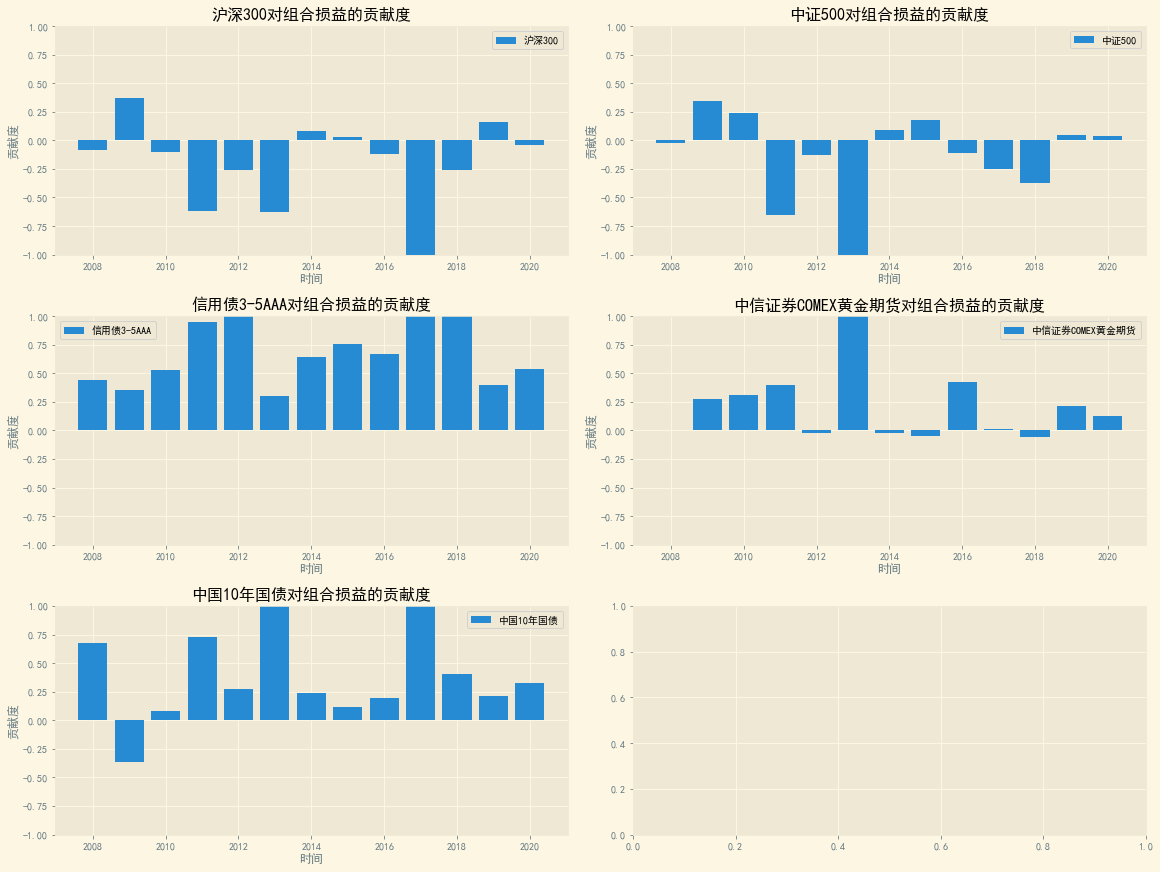

In [60]:
StatisticFunc.BarPlot(annualContrb_5, '铜油比C')

### 投资组合净值曲线

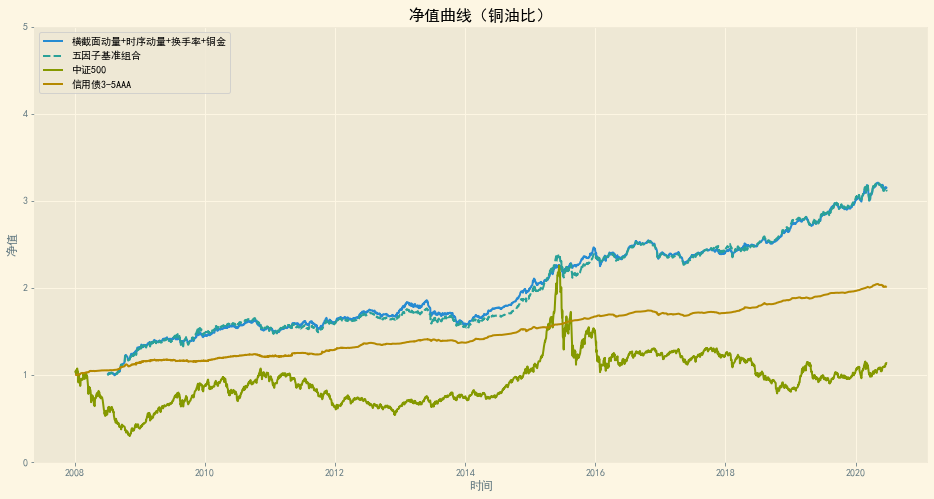

In [61]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_5.index, tradeDF_5['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金')
    
# 基准参考
plt.plot(tradeDF_multi.index, tradeDF_multi['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（铜油比）')
plt.savefig('净值曲线（铜油比）C.png')